# Определение стоимости автомобилей


1. DateCrawled — дата скачивания анкеты из базы
2. VehicleType — тип автомобильного кузова
3. RegistrationYear — год регистрации автомобиля
4. Gearbox — тип коробки передач
5. Power — мощность (л. с.)
6. Model — модель автомобиля
7. Kilometer — пробег (км)
8. RegistrationMonth — месяц регистрации автомобиля
9. FuelType — тип топлива
10. Brand — марка автомобиля
11. NotRepaired — была машина в ремонте или нет
12. DateCreated — дата создания анкеты
13. NumberOfPictures — количество фотографий автомобиля
14. PostalCode — почтовый индекс владельца анкеты (пользователя)
15. LastSeen — дата последней активности пользователя

Price — цена (евро)

## Подготовка данных

In [1]:
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd 
import numpy as np 
import math 

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error 

from sklearn.linear_model import LinearRegression  
from sklearn.tree import DecisionTreeRegressor 

from sklearn.preprocessing import OrdinalEncoder  

from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler  

from sklearn.model_selection import cross_val_score 
from catboost import Pool, CatBoostRegressor, cv 
from lightgbm import LGBMRegressor

In [2]:
df_car=pd.read_csv('/datasets/autos.csv')
df_car.info()
display(df_car.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [3]:
print('Доля пропусков в столбце ,%:') 
rezul=df_car.isna().mean() * 100
print(rezul)
print('Дубликатов = ',df_car.duplicated().sum()) 

Доля пропусков в столбце ,%:
DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64
Дубликатов =  4


**Имеются пропуски в данных и несколько дубликатов. Необходимо определить признаки которые влияют на цена автомобиля**

1. VehicleType — тип автомобильного кузова
2. RegistrationYear — год регистрации автомобиля
3. Gearbox — тип коробки передач
4. Power — мощность (л. с.)
5. Model — модель автомобиля
6. Kilometer — пробег (км)
7. FuelType — тип топлива
8. Brand — марка автомобиля
9. NotRepaired — была машина в ремонте или нет

 

In [4]:
df_car= df_car.drop_duplicates().reset_index(drop=True) 
print('Дубликатов = ',df_car.duplicated().sum()) 

Дубликатов =  0


In [5]:
df_car['Price']=df_car['Price'].astype('int32') 
df_car['RegistrationYear']=df_car['RegistrationYear'].astype('int16') 
df_car['Power']=df_car['Power'].astype('int16') 
df_car['Kilometer']=df_car['Kilometer'].astype('int32')
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int32 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int16 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int16 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int32 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  NotRepaired        283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int16(2), int32(2

In [6]:
df_car_work=df_car[['Price','VehicleType','RegistrationYear','Gearbox','Power','Brand','Model','Kilometer','FuelType','NotRepaired']]
df_car_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int32 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int16 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int16 
 5   Brand             354365 non-null  object
 6   Model             334660 non-null  object
 7   Kilometer         354365 non-null  int32 
 8   FuelType          321470 non-null  object
 9   NotRepaired       283211 non-null  object
dtypes: int16(2), int32(2), object(6)
memory usage: 20.3+ MB


Перевод столбцов в целочисленный тип данных с разным размером, ни как не отразится  на данных, но позволит сэкономить память. Так же исключены не нужные столбцы, рабочий размер данных в памяти уменьшился в 2-е

In [7]:
for i in df_car_work.columns:
    colum_value=df_car_work[i].sort_values().unique() 
    print('столбец',i)
    display(colum_value)

столбец Price


array([    0,     1,     2, ..., 19998, 19999, 20000], dtype=int32)

столбец VehicleType


array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

столбец RegistrationYear


array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

столбец Gearbox


array(['auto', 'manual', nan], dtype=object)

столбец Power


array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

столбец Brand


array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

столбец Model


array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

столбец Kilometer


array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000], dtype=int32)

столбец FuelType


array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

столбец NotRepaired


array(['no', 'yes', nan], dtype=object)

Среди данных много достаточно странных значений, например дата регистрации 1000 или 2066  и т.д.

In [8]:
df_car_work.fillna({'Gearbox':'manual', 
                           'NotRepaired':'yes'},
                          inplace=True)
print('Доля пропусков в столбце ,%:') # проверка на пропуски
rezul=df_car_work.isna().mean() * 100
print(rezul)

Доля пропусков в столбце ,%:
Price                0.000000
VehicleType         10.579487
RegistrationYear     0.000000
Gearbox              0.000000
Power                0.000000
Brand                0.000000
Model                5.560651
Kilometer            0.000000
FuelType             9.282802
NotRepaired          0.000000
dtype: float64


**Восстановить  тип двигателя и соответственно используемого топлива не представляется возможным, поэтому пропуски просто удаляем**

In [9]:
df_car_work['FuelType'] = df_car_work['FuelType'].fillna('unknown')

In [10]:
print('Доля пропусков в столбце ,%:') # проверка на пропуски
rezul=df_car_work.isna().mean() * 100
print(rezul)
print('Доля потерянных данных ,%:')
delta=(len(df_car)-len(df_car_work))/len(df_car)
print(delta)


Доля пропусков в столбце ,%:
Price                0.000000
VehicleType         10.579487
RegistrationYear     0.000000
Gearbox              0.000000
Power                0.000000
Brand                0.000000
Model                5.560651
Kilometer            0.000000
FuelType             0.000000
NotRepaired          0.000000
dtype: float64
Доля потерянных данных ,%:
0.0


**Теперь можно обработать аномальные значения**

In [11]:
for i in df_car_work.columns:
    colum_value=df_car_work[i].sort_values().unique() # Вывод всех уникальных значений  по столбцам
    print('столбец',i)
    display(colum_value)

столбец Price


array([    0,     1,     2, ..., 19998, 19999, 20000], dtype=int32)

столбец VehicleType


array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

столбец RegistrationYear


array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

столбец Gearbox


array(['auto', 'manual'], dtype=object)

столбец Power


array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

столбец Brand


array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

столбец Model


array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

столбец Kilometer


array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000], dtype=int32)

столбец FuelType


array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       'unknown'], dtype=object)

столбец NotRepaired


array(['no', 'yes'], dtype=object)

**Удаление пропусков улучшило ситуацию со странными значнениями, их стало значительно меньше.**

In [12]:
df_car_work['Price'].value_counts() 

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

**Сильно искажают данные 10772 машины со стоимистью 0, для обучения модели эти данные стоит удалить**

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

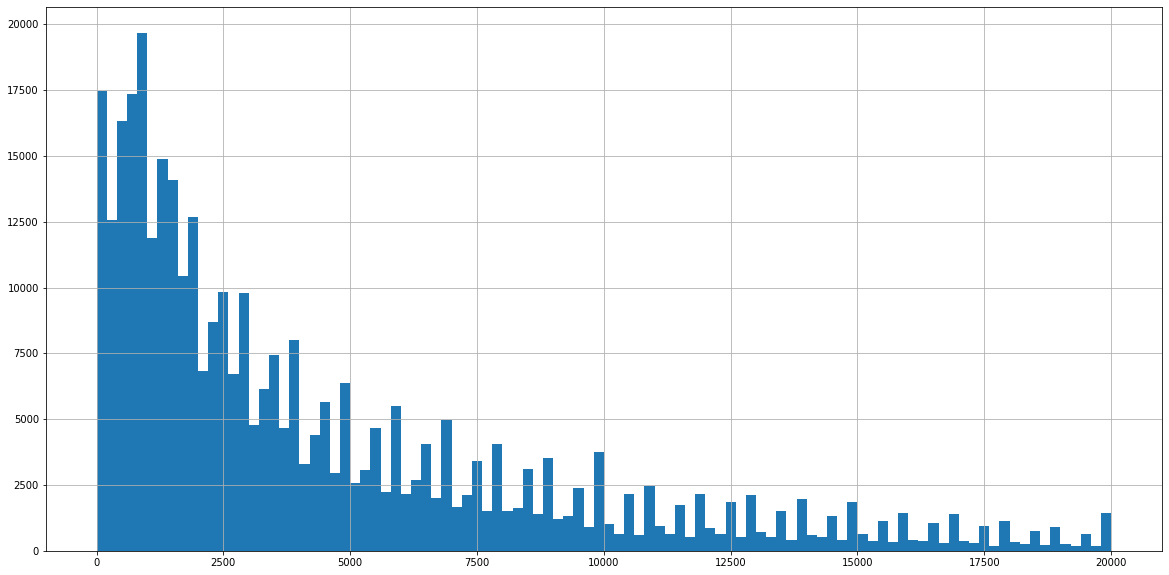

In [13]:
df_car_work['Price'].hist(bins=100, figsize=(20,10)) 
df_car_work['Price'].describe() 

**Столбец Price имеет достаточно много подозрительно низких цен, цен равных 0 или близких к этому значению не должно быть**

In [14]:
n1=len(df_car_work)
hi_filter_price=1 # верхний порог фильтрации
low_filter_price=0.05 # нижний порог фильтрации
filter_price=df_car_work['Price'].quantile([low_filter_price, hi_filter_price]) # Выделим квантили
print(filter_price)

0.05      200.0
1.00    20000.0
Name: Price, dtype: float64


In [15]:
df_car_work = df_car_work.query('@filter_price[@low_filter_price]<= Price <= @filter_price[@hi_filter_price]') 
n2=len(df_car_work)

In [16]:
print(((n1-n2)/n1)*100) # Доля потерянных данных 

4.927687553793405


**Столбец Price теперь имеет адекватные значения**

In [17]:
date = pd.to_datetime(df_car['DateCrawled']) 
date.max()

Timestamp('2016-04-07 14:36:58')

**Таким образом дата регистрации не может быть больше 2016 года**

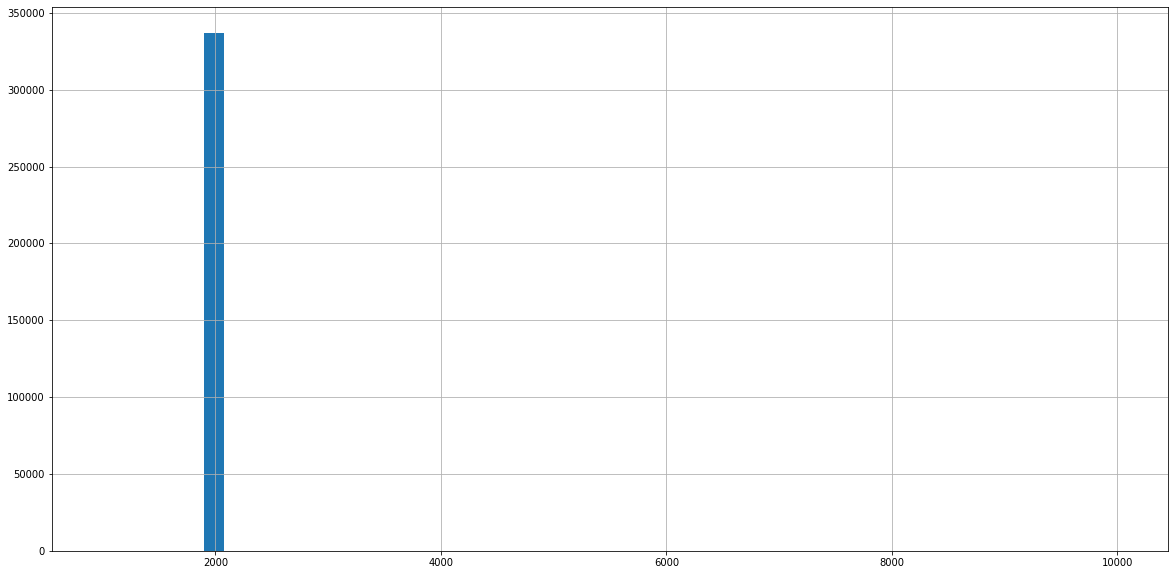

In [18]:
df_car_work['RegistrationYear'].hist(bins=50, figsize=(20,10))
df_car_work['RegistrationYear'].describe()
n1=len(df_car_work)

**Распределение не вызывает ни каких сомнений, но если мы разрабатываем модель для оценки машин массового сегмента, то раритеты стоит отбросить, что бы не создавать больших ошибок при их оценке. Раритетом можно считать автомобиль возрастом более 40 лет**

In [19]:
df_car_work = df_car_work.query('1976 <= RegistrationYear <= 2016')
n2=len(df_car_work)
print(((n1-n2)/n1)*100) 

4.688589890858793


count    321107.000000
mean       2002.918653
std           6.121751
min        1976.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

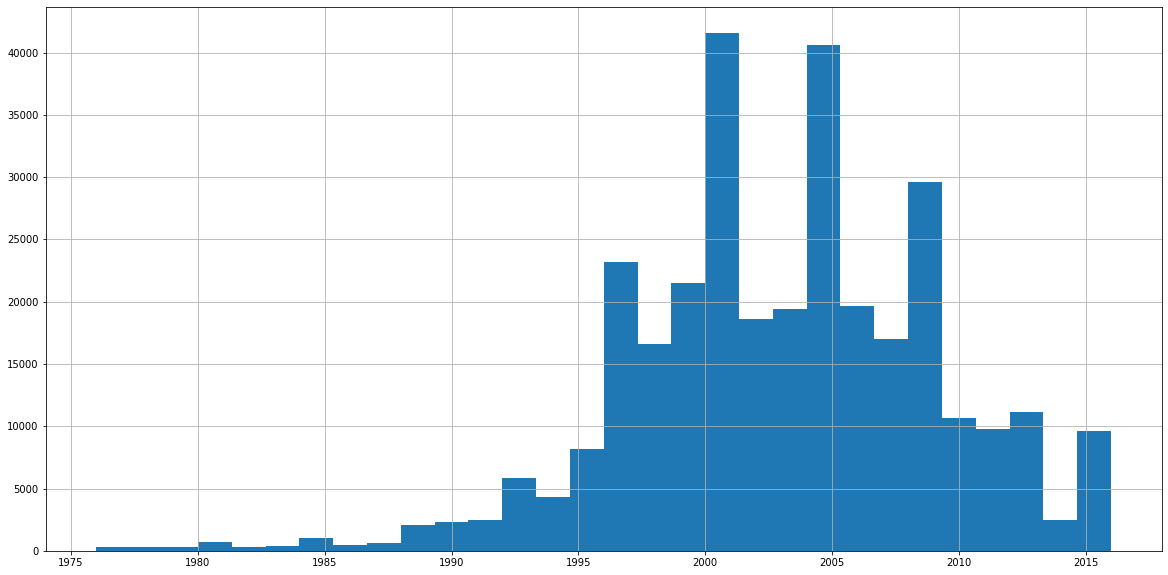

In [20]:
df_car_work['RegistrationYear'].hist(bins=30, figsize=(20,10))
df_car_work['RegistrationYear'].describe()

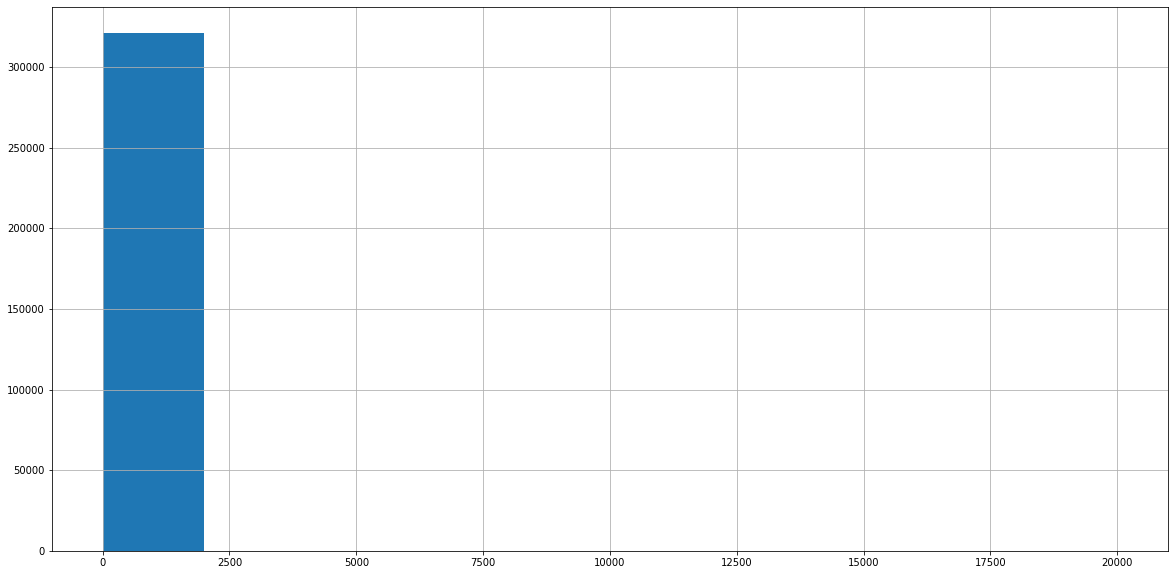

In [21]:
df_car_work['Power'].hist(bins=10, figsize=(20,10))
value=df_car_work['Power'].describe()

**Распределение мощности автомобилей очень странное, есть авто с мощностью 0 и 20000 л.с.**

count    291018.000000
mean        121.331986
std          53.752828
min          12.000000
25%          80.000000
50%         114.000000
75%         150.000000
max         651.000000
Name: Power, dtype: float64

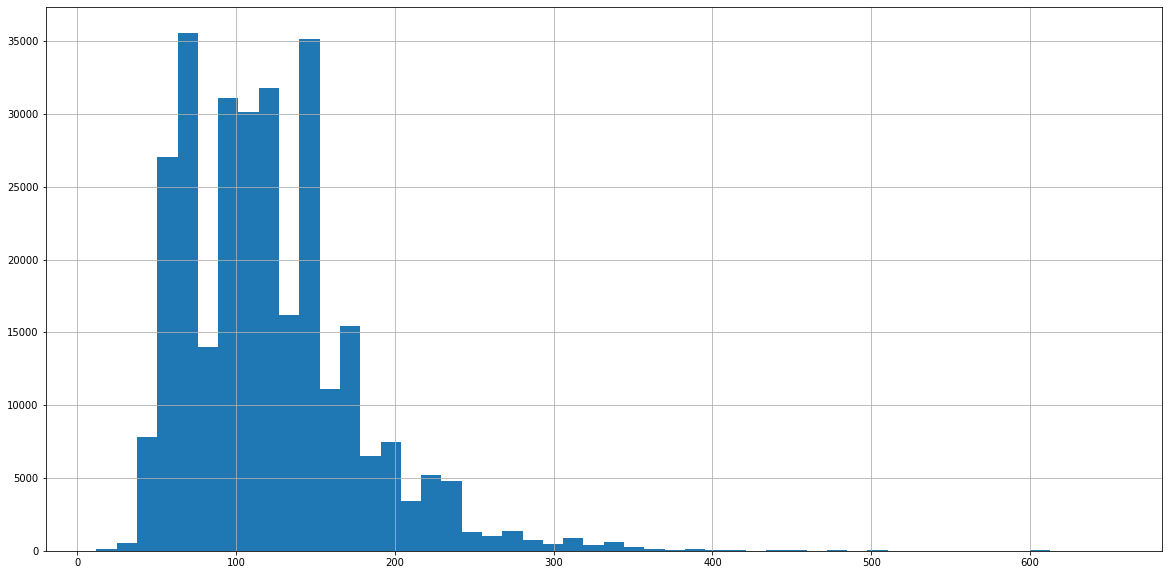

In [22]:
power_max=value['mean']+3*value['std'] #макс мощность
power_min=value['mean']/10# мин мощность
df_car_work = df_car_work.query('@power_min < Power <= @power_max') # Отфильтровали столбец по условию
df_car_work['Power'].hist(bins=50, figsize=(20,10))
df_car_work['Power'].describe()

**Диапазон выбран из соображений статистики**

In [23]:
print('Доля пропусков в столбце ,%:') 
rezul= df_car_work.isna().mean() * 100
print(rezul)

Доля пропусков в столбце ,%:
Price               0.000000
VehicleType         3.540331
RegistrationYear    0.000000
Gearbox             0.000000
Power               0.000000
Brand               0.000000
Model               3.561979
Kilometer           0.000000
FuelType            0.000000
NotRepaired         0.000000
dtype: float64


In [24]:
df_car_work=df_car_work.reset_index(drop=True)
display(df_car_work.head(30))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Brand,Model,Kilometer,FuelType,NotRepaired
0,18300,coupe,2011,manual,190,audi,NaN,125000,gasoline,yes
1,9800,suv,2004,auto,163,jeep,grand,125000,gasoline,yes
2,1500,small,2001,manual,75,volkswagen,golf,150000,petrol,no
3,3600,small,2008,manual,69,skoda,fabia,90000,gasoline,no
4,650,sedan,1995,manual,102,bmw,3er,150000,petrol,yes
5,2200,convertible,2004,manual,109,peugeot,2_reihe,150000,petrol,no
6,14500,bus,2014,manual,125,ford,c_max,30000,petrol,yes
7,999,small,1998,manual,101,volkswagen,golf,150000,unknown,yes
8,2000,sedan,2004,manual,105,mazda,3_reihe,150000,petrol,no
9,2799,wagon,2005,manual,140,volkswagen,passat,150000,gasoline,yes


**заменим пропуски в столбце VehicleType на наиболее частое значение для бренда**

In [25]:
def get_key(d, value): #поик ключа  по значению
    for k, v in d.items():
        if v == value:
            return k

In [26]:
df_car_work['VehicleType']= df_car_work['VehicleType'].fillna('No')

df_value=df_car_work[['Brand','VehicleType']]
brand=df_value['Brand'].unique()
for ij in brand:
    df_brand=df_value.query('Brand ==@ij') #срез по марке

    brand_model=df_brand.groupby('VehicleType')['VehicleType'].count()
    
    brand_max=brand_model.max()
    model=get_key(brand_model,brand_max)

    for i in range(len(df_car_work)):
        if df_car_work['Brand'][i]==ij:
            if df_car_work['VehicleType'][i]=='No':
   
                df_car_work['VehicleType'][i]=model


**заменим пропуски в столбце Model на наиболее частое значение для бренда**

In [27]:
df_car_work['Model']= df_car_work['Model'].fillna('No')

df_value=df_car_work[['Brand','Model']]
brand=df_value['Brand'].unique()
for ij in brand:
    df_brand=df_value.query('Brand ==@ij') #срез по марке

    brand_model=df_brand.groupby('Model')['Model'].count()

    brand_max=brand_model.max()
    model=get_key(brand_model,brand_max)

    for i in range(len(df_car_work)):
        if df_car_work['Brand'][i]==ij:
            if df_car_work['Model'][i]=='No':
            #print('y NaN')
                df_car_work['Model'][i]=model

In [28]:
print('Доля пропусков в столбце ,%:') 
rezul= df_car_work.isna().mean() * 100
print(rezul)

Доля пропусков в столбце ,%:
Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Brand               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
NotRepaired         0.0
dtype: float64


In [30]:
print("Осталось данных от первоначального объема")
delta=1-(len(df_car)-len(df_car_work))/len(df_car)
print(delta)


Осталось данных от первоначального объема
0.8212379890790569


## Обучение моделей

Выберем следующие регрессоры для обучения модели:

1. LinearRegression
2. DecisionTreeRegressor
3. CatBoostRegressor
4. LGBMRegressor


**Так как признаки Gearbox и NotRepaired бинарные, то их можно преобразовать в 0 и 1**

In [31]:
df_car_work= pd.get_dummies(df_car_work, columns=['Gearbox', 'NotRepaired'],drop_first=True) # дамми преобразование

In [32]:
display(df_car_work)

,Price,VehicleType,RegistrationYear,Power,Brand,Model,Kilometer,FuelType,Gearbox_manual,NotRepaired_yes
0,18300,coupe,2011,190,audi,a4,125000,gasoline,1,1
1,9800,suv,2004,163,jeep,grand,125000,gasoline,0,1
2,1500,small,2001,75,volkswagen,golf,150000,petrol,1,0
3,3600,small,2008,69,skoda,fabia,90000,gasoline,1,0
4,650,sedan,1995,102,bmw,3er,150000,petrol,1,1
...,...,...,...,...,...,...,...,...,...,...
291013,5250,sedan,2016,150,alfa_romeo,159,150000,unknown,0,0
291014,3200,sedan,2004,225,seat,leon,150000,petrol,1,1
291015,1199,convertible,2000,101,smart,fortwo,125000,petrol,0,0
291016,9200,bus,1996,102,volkswagen,transporter,150000,gasoline,1,0


In [33]:

features= df_car_work.drop('Price', axis=1)

target =df_car_work['Price']
display(features.head(10)) 

,VehicleType,RegistrationYear,Power,Brand,Model,Kilometer,FuelType,Gearbox_manual,NotRepaired_yes
0,coupe,2011,190,audi,a4,125000,gasoline,1,1
1,suv,2004,163,jeep,grand,125000,gasoline,0,1
2,small,2001,75,volkswagen,golf,150000,petrol,1,0
3,small,2008,69,skoda,fabia,90000,gasoline,1,0
4,sedan,1995,102,bmw,3er,150000,petrol,1,1
5,convertible,2004,109,peugeot,2_reihe,150000,petrol,1,0
6,bus,2014,125,ford,c_max,30000,petrol,1,1
7,small,1998,101,volkswagen,golf,150000,unknown,1,1
8,sedan,2004,105,mazda,3_reihe,150000,petrol,1,0
9,wagon,2005,140,volkswagen,passat,150000,gasoline,1,1


In [34]:
# разделяем на выборку для обучения и тестирования, 25% данных для валидации (теста)
features_train_OE, features_test_OE, target_train_OE, target_test_OE = train_test_split(features, target, test_size=0.25, random_state=2504)

In [35]:
categorii_columns = ['VehicleType','Brand','Model','FuelType']  #Категориальные признаки 
encoder = OrdinalEncoder() #Порядковое кодирование
features_train_OE[categorii_columns]=encoder.fit_transform(features_train_OE[categorii_columns]) # шифруем категориальные признаки
features_test_OE[categorii_columns]=encoder.transform(features_test_OE[categorii_columns])
display(features_train_OE.head(10))

,VehicleType,RegistrationYear,Power,Brand,Model,Kilometer,FuelType,Gearbox_manual,NotRepaired_yes
62989,4.0,1994,60,38.0,174.0,150000,6.0,1,0
174452,5.0,2001,60,23.0,152.0,150000,6.0,1,1
207462,5.0,2010,68,36.0,47.0,70000,6.0,1,0
92669,4.0,1999,75,38.0,117.0,150000,6.0,1,0
97574,4.0,1999,75,24.0,43.0,150000,6.0,1,0
65307,4.0,2007,163,2.0,11.0,150000,2.0,0,0
187437,1.0,1995,75,24.0,43.0,150000,7.0,1,0
119263,4.0,2003,116,20.0,60.0,150000,2.0,1,1
21468,7.0,2012,140,38.0,171.0,150000,2.0,0,0
95519,4.0,2003,102,38.0,117.0,150000,6.0,0,0


### Линейная регрессия

In [37]:
# Так как для линейной регрессии не подходит порядковое кодирование признаков используем прямое кодирование (OHE )
ohe_features = pd.get_dummies(features, drop_first=True)
# разделяем на выборку для обучения и тестирования, 25% данных для валидации (теста)
features_train_OHE, features_test_OHE, target_train_OHE, target_test_OHE = train_test_split(ohe_features, target, test_size=0.25, random_state=2504)


In [87]:
%%time
model_line = LinearRegression()
line_regess_CVS = (cross_val_score(model_line, 
                             features_train_OHE, 
                             target_train_OHE, 
                             cv=5, 
                             scoring='neg_mean_squared_error'))
                            
result_1=math.sqrt(-line_regess_CVS.mean())
print(f'Cреднеквадратичная ошибка RMSE при кросс валидации = {result_1:.4}') 

Cреднеквадратичная ошибка RMSE при кросс валидации = 2.494e+03
CPU times: user 1min 1s, sys: 1min 14s, total: 2min 15s
Wall time: 2min 16s


### Модель, дерево решений

**Порядковое кодирование признаков**

In [88]:
%%time
model_DTR = DecisionTreeRegressor() # модель
parametrs=[{ 
    'max_depth':range(1,30,1),  
    'criterion':['mse'],  
    'random_state':[2504] 
}]
search_best_param=GridSearchCV(model_DTR, 
                               parametrs, 
                                cv=5, 
                               scoring='neg_mean_squared_error') 
search_best_param.fit(features_train_OE,  target_train_OE) 
print('Cреднеквадратичная ошибка RMSE при кросс валидации')
means =search_best_param.cv_results_['mean_test_score']
stds = search_best_param.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search_best_param.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()
print("Наилучшие найденые параметры:")
print()
print(search_best_param.best_params_)


Cреднеквадратичная ошибка RMSE при кросс валидации
3625.108387 for {'criterion': 'mse', 'max_depth': 1, 'random_state': 2504}
3152.929954 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 2504}
2878.260040 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 2504}
2557.345993 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 2504}
2381.214588 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 2504}
2240.768924 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 2504}
2136.670499 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 2504}
2051.742359 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 2504}
1995.066849 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 2504}
1940.650277 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 2504}
1899.665998 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 2504}
1867.445986 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 2504}
1856.670242 for {'criterion': 'mse', 'max_dept

**Прямое кодирование (OHE ) признаков**

In [89]:
 %%time
model_DTR = DecisionTreeRegressor() # модель
parametrs=[{ 
    'max_depth':range(1,30,1),  
    'criterion':['mse'],  
    'random_state':[2504] 
}]
search_best_param=GridSearchCV(model_DTR,  
                               parametrs, 
                                cv=5, 
                               scoring='neg_mean_squared_error')  
search_best_param.fit(features_train_OHE,  target_train_OHE) 
print('Cреднеквадратичная ошибка RMSE при кросс валидации')
means =search_best_param.cv_results_['mean_test_score']
stds = search_best_param.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search_best_param.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()
print("Наилучшие найденые параметры:")
print()
print(search_best_param.best_params_)

Cреднеквадратичная ошибка RMSE при кросс валидации
3625.108387 for {'criterion': 'mse', 'max_depth': 1, 'random_state': 2504}
3152.929954 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 2504}
2878.260040 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 2504}
2559.662066 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 2504}
2386.294542 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 2504}
2237.626427 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 2504}
2137.699070 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 2504}
2058.388056 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 2504}
2001.258007 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 2504}
1948.566157 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 2504}
1905.154734 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 2504}
1873.738509 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 2504}
1853.352304 for {'criterion': 'mse', 'max_dept

**Вывод  модель дерева решений для OE и OHE  замены категориальных признаков имют RMSE очень близкое и лучший результат при глубине дерева 14 и 16 соответственно. Обе модели достигли показателя RMSE в 1859 и 1821 соответственно**

### Модель,  CatBoostRegressor регрессия

**Так как CatBoost позволяет не преобразовывать категориальные признаки, будем использовать не преобразованные данные**

In [41]:
# разделяем на выборку для обучения и тестирования, 25% данных для валидации (теста)
features_train_original, features_test_original, target_train_original, target_test_original = train_test_split(features, target, test_size=0.25, random_state=2504)

In [42]:
%%time
model_CatBR = CatBoostRegressor()
parametrs=[{'learning_rate':[0.3,0.5,0.7], 
                              'iterations': [200], 
                              'depth': [5], 
                              'random_state':[2504], 
                              'verbose':[False], 
                              'cat_features':[categorii_columns]}] 
search_best_param_CatBR=GridSearchCV(model_CatBR,parametrs,scoring='neg_mean_squared_error')
search_best_param_CatBR.fit(features_train_original, 
                                target_train_original) 

CPU times: user 5min 28s, sys: 1.32 s, total: 5min 29s
Wall time: 5min 42s


GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7f0ddfbf8d30>,
             param_grid=[{'cat_features': [['VehicleType', 'Brand', 'Model',
                                            'FuelType']],
                          'depth': [5], 'iterations': [200],
                          'learning_rate': [0.3, 0.5, 0.7],
                          'random_state': [2504], 'verbose': [False]}],
             scoring='neg_mean_squared_error')

In [43]:
print(search_best_param_CatBR.cv_results_['params'])

[{'cat_features': ['VehicleType', 'Brand', 'Model', 'FuelType'], 'depth': 5, 'iterations': 200, 'learning_rate': 0.3, 'random_state': 2504, 'verbose': False}, {'cat_features': ['VehicleType', 'Brand', 'Model', 'FuelType'], 'depth': 5, 'iterations': 200, 'learning_rate': 0.5, 'random_state': 2504, 'verbose': False}, {'cat_features': ['VehicleType', 'Brand', 'Model', 'FuelType'], 'depth': 5, 'iterations': 200, 'learning_rate': 0.7, 'random_state': 2504, 'verbose': False}]


In [44]:
means = search_best_param_CatBR.cv_results_['mean_test_score']
for mean, params in zip(means, search_best_param_CatBR.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5,parametrs))
print()                       
print('Mean RMSE from CV of CatBoostRegressor =', search_best_param_CatBR)
print(search_best_param_CatBR)

1632.950156 for [{'learning_rate': [0.3, 0.5, 0.7], 'iterations': [200], 'depth': [5], 'random_state': [2504], 'verbose': [False], 'cat_features': [['VehicleType', 'Brand', 'Model', 'FuelType']]}]
1618.786505 for [{'learning_rate': [0.3, 0.5, 0.7], 'iterations': [200], 'depth': [5], 'random_state': [2504], 'verbose': [False], 'cat_features': [['VehicleType', 'Brand', 'Model', 'FuelType']]}]
1621.707410 for [{'learning_rate': [0.3, 0.5, 0.7], 'iterations': [200], 'depth': [5], 'random_state': [2504], 'verbose': [False], 'cat_features': [['VehicleType', 'Brand', 'Model', 'FuelType']]}]

Mean RMSE from CV of CatBoostRegressor = GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7f0ddfbf8d30>,
             param_grid=[{'cat_features': [['VehicleType', 'Brand', 'Model',
                                            'FuelType']],
                          'depth': [5], 'iterations': [200],
                          'learning_rate': [0.3, 0.5, 0.7],
                          'r

In [45]:
model_CatBR = CatBoostRegressor(learning_rate= 0.5, 
                              iterations= 200,
                              depth= 5,
                             random_state= 2504, 
                              verbose=False, 
                              cat_features=categorii_columns)
cross_val_score_CatBR= cross_val_score(model_CatBR, 
                                              features_train_original, 
                                target_train_original, 
                                              cv=5,
                                       scoring='neg_mean_squared_error').mean()

In [76]:
print(f'Cреднеквадратичная ошибка RMSE после кросс валидации = {(cross_val_score_CatBR*-1)** 0.5:.4}')

Cреднеквадратичная ошибка RMSE после кросс валидации = 1.619e+03


**Вывод**
Модель показала хорошую скорость работы и не требует преобразования категориальных данных, 1619 RMSE для лучшего варианта параметров 

### Модель LGBMRegressor

In [47]:
%%time
model_LGBMR = LGBMRegressor() 
params = [{'num_iterations': [10, 50, 100, 500, 1000],
            'max_depth': [3, 5, 7],
            'random_state':[2504]}]
search_best_param_LGBMR = GridSearchCV(model_LGBMR, params, scoring='neg_mean_squared_error')
search_best_param_LGBMR.fit(features_train_OE, target_train_OE)
print(search_best_param_LGBMR.best_params_)

{'max_depth': 7, 'num_iterations': 1000, 'random_state': 2504}
CPU times: user 1h 19min 14s, sys: 48.4 s, total: 1h 20min 3s
Wall time: 1h 20min 32s


In [48]:
means = search_best_param_LGBMR.cv_results_['mean_test_score']
stds = search_best_param_LGBMR.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search_best_param_LGBMR.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()
cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

2937.147547 for {'max_depth': 3, 'num_iterations': 10, 'random_state': 2504}
2024.833130 for {'max_depth': 3, 'num_iterations': 50, 'random_state': 2504}
1886.049396 for {'max_depth': 3, 'num_iterations': 100, 'random_state': 2504}
1710.123392 for {'max_depth': 3, 'num_iterations': 500, 'random_state': 2504}
1661.684987 for {'max_depth': 3, 'num_iterations': 1000, 'random_state': 2504}
2624.343839 for {'max_depth': 5, 'num_iterations': 10, 'random_state': 2504}
1804.945034 for {'max_depth': 5, 'num_iterations': 50, 'random_state': 2504}
1717.142144 for {'max_depth': 5, 'num_iterations': 100, 'random_state': 2504}
1594.109311 for {'max_depth': 5, 'num_iterations': 500, 'random_state': 2504}
1563.600738 for {'max_depth': 5, 'num_iterations': 1000, 'random_state': 2504}
2603.306392 for {'max_depth': 7, 'num_iterations': 10, 'random_state': 2504}
1764.592865 for {'max_depth': 7, 'num_iterations': 50, 'random_state': 2504}
1681.840763 for {'max_depth': 7, 'num_iterations': 100, 'random_stat

**кросс валидация**

In [82]:
model_LGBMR = LGBMRegressor(num_iterations= 1000,
            max_depth= 7,
            random_state=2504) 
cross_val_score_LGBMR= cross_val_score(model_LGBMR, 
                                             features_train_OE,
                                       target_train_OE, 
                                        cv=5,
                                       scoring='neg_mean_squared_error').mean()

In [86]:
print(f'Cреднеквадратичная ошибка RMSE после кросс валидации = {(cross_val_score_LGBMR*-1)** 0.5:.4}')


Cреднеквадратичная ошибка RMSE после кросс валидации = 1.541e+03


## Анализ моделей по времени предсказания

### Линейная регрессия

In [68]:
%%time
model_line.fit(features_train_OHE, target_train_OHE)  # обучение модели

CPU times: user 14.7 s, sys: 15 s, total: 29.6 s
Wall time: 29.9 s


LinearRegression()

In [70]:
%%time 
predictions_line = model_line.predict(features_test_OHE) # результаты предсказания модели

CPU times: user 109 ms, sys: 103 ms, total: 212 ms
Wall time: 203 ms


### Модель, дерево решений

**Порядковое кодирование признаков**

In [71]:
%%time 

model_DTR_1 = DecisionTreeRegressor(random_state=2504, max_depth=14).fit(features_train_OE,  target_train_OE) 

CPU times: user 521 ms, sys: 0 ns, total: 521 ms
Wall time: 524 ms


In [72]:
predictions_DTR_1 = model_DTR_1.predict(features_test_OE)

**Прямое кодирование (OHE ) признаков**

In [57]:
%%time 

model_DTR_2 = DecisionTreeRegressor(random_state=2504, max_depth=19).fit(features_train_OHE,  target_train_OHE) 

CPU times: user 5.32 s, sys: 130 ms, total: 5.45 s
Wall time: 5.46 s


In [58]:
%%time 
predictions_DTR_2 = model_DTR_2.predict(features_test_OHE) 

CPU times: user 51.4 ms, sys: 51.4 ms, total: 103 ms
Wall time: 111 ms


### Модель,  CatBoostRegressor регрессия

In [60]:
%%time 
model_CatBR = CatBoostRegressor(learning_rate=0.5, 
                                
                              iterations=200, 
                            
                              depth=5, 
                              random_state=2504, 
                              verbose=False, 
                              cat_features=categorii_columns) 
model_CatBR.fit(features_train_original,target_train_original) 

CPU times: user 24 s, sys: 82.8 ms, total: 24.1 s
Wall time: 24.8 s


In [61]:
%%time 
predictions_CatBR = model_CatBR.predict(features_test_original)

CPU times: user 124 ms, sys: 4.13 ms, total: 128 ms
Wall time: 130 ms


### Модель LGBMRegressor

In [92]:
%%time
model_LGBMR = LGBMRegressor(num_iterations=1000,
            max_depth= 7,
            random_state=2504)
model_LGBMR.fit(features_train_OE, target_train_OE) 

CPU times: user 47min 9s, sys: 29.4 s, total: 47min 38s
Wall time: 47min 54s


LGBMRegressor(max_depth=7, num_iterations=1000, random_state=2504)

In [93]:
%%time
predictions_LGBMR = model_LGBMR.predict(features_test_OE) 

CPU times: user 7.79 s, sys: 64.4 ms, total: 7.85 s
Wall time: 7.88 s


### Вывод

1. Более сложные модели машинного обучения требуют большего времени на обучение, но достигают лучшей точности в предсказании
2. Гипер параметры  сильно влияют на время обучения, но могут не значительно оказывать влияние на результат
3. Наиболее успешными моделями из 4-х рассмотренных стали LGBMRegressor и CatBoostRegressor
4. CatBoostRegressor не требует преобразований категориальных переменных и иметт достаточно хорошую скорость обучения в сравнении с   моделью LGBMRegressor
5. Наилучший результат по показателям RSME, показала модель LGBMRegressor, соответственно ее в дальнейшем и будем использовать.

## Тест выбранной модели, LGBMRegressor

In [94]:
%%time 
predictions_LGBMR = model_LGBMR.predict(features_test_OE)
result_LGBMR =math.sqrt(mean_squared_error(target_test_OE, predictions_LGBMR,squared=True)) 
print(f'Cреднеквадратичная ошибка RMSE = {result_LGBMR:.4}') # среднеквадратичная ошибка


Cреднеквадратичная ошибка RMSE = 1.542e+03
CPU times: user 7.9 s, sys: 6.58 ms, total: 7.9 s
Wall time: 7.91 s
